<a href="https://colab.research.google.com/github/shan23chen/sae_llava/blob/main/MOSAIC_Figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Todo
- [ ] Add baselines for tfidf and last token linear probing


---

# MOSAIC: Multilingual and Multimodal Observations of Sparse Autoencoders for Interpretable Classification

---

## 1. Setup and Environment Configuration

### 1.1. Mount Google Drive (Optional)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2. Clone the Repository (with Secure PAT Authentication)

In [2]:
import os
from google.colab import userdata

github_username=userdata.get('GIT_USERNAME')
github_token=userdata.get('GIT_TOKEN')

# Set environment variables
os.environ['GIT_USERNAME'] = github_username
os.environ['GIT_TOKEN'] = github_token

repo_url = "github.com/shan23chen/sae_llava.git"

!git clone https://{github_username}:{github_token}@{repo_url}
%cd sae_llava

fatal: destination path 'sae_llava' already exists and is not an empty directory.
/content/sae_llava


### 1.3. Install Minimal Dependencies

In [3]:
!pip install pandas matplotlib seaborn pyyaml

### 1.4. Verify Directory and Configuration

In [4]:
!pwd  # Should be /content/sae_llava
!ls  # Check if config_jg.yaml is present
!ls config_jg.yaml

/content/sae_llava
app		 config_ks.yaml  output		run_experiments.py  vlm_transfer_figures.ipynb
code-review.csv  config_sc.yaml  __pycache__	run_shan.sh
configc.yaml	 config.yaml	 readme.md	setup.py
config_jg.yaml	 interactive	 results.ipynb	src
config_jg.yaml


---

## 2. Data Loading and Collation

### 2.1. Load Configuration

In [5]:
import pandas as pd
import os
import json
import csv
from datetime import datetime
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

# Load Configuration from the cloned repository
with open("config_jg.yaml", "r") as f:
    config = yaml.safe_load(f)
    dashboard_dir = config["settings"]["base_classify_dir"]

### 2.2. Data Collation Function

In [6]:
def extract_scores(dashboard_dir, output_csv):
    """
    Traverse the dashboard directory, extract macro avg F1 scores from JSON files,
    and save to a CSV file along with relevant metadata.
    Also handles NaN values in 'binarize_value' by converting them to 0 (False).

    Parameters:
        dashboard_dir (str): Base directory containing the structured dashboard outputs.
        output_csv (str): Path to save the resulting CSV file.
    """
    entries_processed = 0

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    # Open the CSV file for writing
    with open(output_csv, mode="w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)

        # Write CSV header
        csv_writer.writerow(
            [
                "timestamp",
                "model_name",
                "model_type",
                "sae_location",
                "layer",
                "width",
                "type",
                "dataset_name",
                "dataset_config_name",
                "dataset_split",
                "top_n",
                "binarize_value",
                "last_token",
                "linear_macro_f1_score",
                "linear_accuracy",
                "linear_mean_cv_accuracy",
                "linear_std_cv_accuracy",
                "decision_tree_macro_f1_score",
                "decision_tree_accuracy",
                "decision_tree_mean_cv_accuracy",
                "decision_tree_std_cv_accuracy",
            ]
        )

        # Traverse the dashboard directory
        for root, _, files in os.walk(dashboard_dir):
            for file in files:
                if file.endswith(".json"):
                    json_path = os.path.join(root, file)

                    try:
                        # Load the JSON file
                        with open(json_path, "r") as f:
                            data = json.load(f)

                        # Extract metadata
                        metadata = data.get("metadata", {})
                        models = data.get("models", {})

                        timestamp = metadata.get("timestamp", "N/A")
                        model_name = metadata.get("model", {}).get("name", "N/A")
                        layer = metadata.get("model", {}).get("layer", "N/A")

                        args = metadata.get("args", {})
                        width = args.get("width", "N/A")
                        dataset_name = metadata.get("dataset", {}).get("name", "N/A")
                        dataset_split = args.get("dataset_split", "N/A")

                        model_type = args.get("model_type", "N/A")
                        sae_location = args.get("sae_location", "N/A")
                        dataset_config_name = args.get("dataset_config_name", "N/A")
                        top_n = args.get("top_n", "N/A")
                        binarize_value = args.get("binarize_value", "N/A")
                        last_token = args.get("last_token", "N/A")

                        hidden = metadata.get("dataset", {}).get("hidden", "N/A")

                        if hidden:
                            hidden_value = "Hidden States"
                        else:
                            hidden_value = "SAE Features"

                        # Handle NaN values in binarize_value: convert to 0 (False)
                        if binarize_value == "N/A" or pd.isna(binarize_value):
                            binarize_value = 0
                        else:
                            binarize_value = int(binarize_value)

                        # Extract Linear Probe metrics
                        linear_probe = models.get("linearProbe", {})
                        linear_macro_avg = linear_probe.get(
                            "aggregated_metrics", {}
                        ).get("macro avg", {})
                        linear_f1_score = linear_macro_avg.get("f1_score", "N/A")

                        linear_performance = linear_probe.get("performance", {})
                        linear_accuracy = linear_performance.get("accuracy", "N/A")
                        linear_cv = linear_performance.get("cross_validation", {})
                        linear_mean_cv_accuracy = linear_cv.get("mean_accuracy", "N/A")
                        linear_std_cv_accuracy = linear_cv.get("std_accuracy", "N/A")

                        # Extract Decision Tree metrics
                        decision_tree = models.get("decisionTree", {})
                        decision_tree_macro_avg = decision_tree.get(
                            "aggregated_metrics", {}
                        ).get("macro avg", {})
                        decision_tree_f1_score = decision_tree_macro_avg.get(
                            "f1_score", "N/A"
                        )

                        decision_tree_performance = decision_tree.get("performance", {})
                        decision_tree_accuracy = decision_tree_performance.get(
                            "accuracy", "N/A"
                        )
                        decision_tree_cv = decision_tree_performance.get(
                            "cross_validation", {}
                        )
                        decision_tree_mean_cv_accuracy = decision_tree_cv.get(
                            "mean_accuracy", "N/A")
                        decision_tree_std_cv_accuracy = decision_tree_cv.get(
                            "std_accuracy", "N/A")

                        # Append extracted data to CSV
                        csv_writer.writerow(
                            [
                                timestamp,
                                model_name,
                                model_type,
                                sae_location,
                                layer,
                                width,
                                hidden_value,
                                dataset_name,
                                dataset_config_name,
                                dataset_split,
                                top_n,
                                binarize_value,
                                last_token,
                                linear_f1_score,
                                linear_accuracy,
                                linear_mean_cv_accuracy,
                                linear_std_cv_accuracy,
                                decision_tree_f1_score,
                                decision_tree_accuracy,
                                decision_tree_mean_cv_accuracy,
                                decision_tree_std_cv_accuracy,
                            ]
                        )

                        entries_processed += 1

                    except Exception as e:
                        print(f"Error processing {json_path}: {e}")

    print(f"Processed {entries_processed} entries.")
    print(f"Results saved to {output_csv}")

### 2.3. Collate Results into CSV

In [7]:
output_csv = os.path.join(dashboard_dir, "classify_scores.csv")
extract_scores(dashboard_dir, output_csv)

Error processing ./output/classifications/google_gemma-2-2b/Anthropic_election_questions/layer_5/16k/20241210_232814/hidden_classifier_results.json: Expecting value: line 5423 column 14 (char 131625)
Processed 12 entries.
Results saved to ./output/classifications/classify_scores.csv


### 2.4. Create a copy of the Original Dataframe

In [8]:
df = pd.read_csv(output_csv)
df_original = df.copy()

### 2.5. Data Filtering

In [9]:
df = df_original.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timestamp                       12 non-null     object 
 1   model_name                      12 non-null     object 
 2   model_type                      12 non-null     object 
 3   sae_location                    12 non-null     object 
 4   layer                           12 non-null     int64  
 5   width                           12 non-null     object 
 6   type                            12 non-null     object 
 7   dataset_name                    12 non-null     object 
 8   dataset_config_name             0 non-null      float64
 9   dataset_split                   12 non-null     object 
 10  top_n                           12 non-null     int64  
 11  binarize_value                  12 non-null     int64  
 12  last_token                      12 non

In [11]:
df.head()

,timestamp,model_name,model_type,sae_location,layer,width,type,dataset_name,dataset_config_name,dataset_split,...,binarize_value,last_token,linear_macro_f1_score,linear_accuracy,linear_mean_cv_accuracy,linear_std_cv_accuracy,decision_tree_macro_f1_score,decision_tree_accuracy,decision_tree_mean_cv_accuracy,decision_tree_std_cv_accuracy
0,2024-12-10T19:01:35.841443,google/gemma-2-2b,llm,res,12,16k,SAE Features,Anthropic/election_questions,NaN,test,...,0,False,0.989919,0.989933,0.973034,0.028953,0.932737,0.932886,0.932584,0.023569
1,2024-12-10T19:01:35.838037,google/gemma-2-2b,llm,res,12,16k,Hidden States,Anthropic/election_questions,NaN,test,...,0,False,0.976478,0.976510,0.986517,0.004494,0.915894,0.916107,0.916854,0.038662
2,2024-12-10T23:31:53.869876,google/gemma-2-2b,llm,res,12,16k,SAE Features,Anthropic/election_questions,NaN,test,...,0,False,0.983179,0.983221,0.973034,0.023136,0.932737,0.932886,0.932584,0.023569
3,2024-12-10T23:31:53.867057,google/gemma-2-2b,llm,res,12,16k,Hidden States,Anthropic/election_questions,NaN,test,...,0,False,0.973111,0.973154,0.986517,0.004494,0.915894,0.916107,0.916854,0.038662
4,2024-12-10T19:01:05.703317,google/gemma-2-2b,llm,res,5,16k,SAE Features,Anthropic/election_questions,NaN,test,...,0,False,0.959642,0.959732,0.968539,0.014906,0.895775,0.895973,0.898876,0.022472


---

## 3. Data Analysis and Visualization

### 3.1. Exploration of SAE Hyperparameters on Classification Performance

#### 3.1.1. Filtering for Specific Tasks

In [30]:
# --- 1. Filter for relevant Hugging Face classification datasets and 'SAE Features' ---
relevant_datasets = [
    "Anthropic/election_questions",
    "AIM-Harvard/reject_prompts",
    "jackhhao/jailbreak-classification",
    "willcb/massive-intent",
    "willcb/massive-scenario",
    "legacy-datasets/banking77",
    "SetFit/tweet_eval_stance_abortion"
]

# We only want rows where dataset_name is in relevant_datasets and type == "SAE Features"
df_filtered = df[
    (df["dataset_name"].isin(relevant_datasets)) &
    (df["type"] == "SAE Features")
].copy()


#### 3.1.2. Hyperparameter variations


In [31]:
# --- 2. Create summary tables (mean and std) of linear_macro_f1_score ---
# Group by hyperparameters to see their impact
summary_cols = ["binarize_value", "top_n", "layer", "width"]

# Compute mean and std for linear_macro_f1_score
grouped_linear = df_filtered.groupby(summary_cols)["linear_macro_f1_score"].agg(["mean", "std"])
grouped_linear = grouped_linear.reset_index().rename(columns={"mean": "F1_mean", "std": "F1_std"})

print("=== Summary of linear_macro_f1_score by hyperparameters ===")
print(grouped_linear.to_string(index=False))
print("\n")


=== Summary of linear_macro_f1_score by hyperparameters ===
 binarize_value  top_n  layer width  F1_mean   F1_std
              0      0      5   16k 0.961330 0.002386
              0      0     12   16k 0.986549 0.004766
              0      0     19   16k 0.936241 0.009491




In [32]:
grouped_tree = df_filtered.groupby(summary_cols)["decision_tree_macro_f1_score"].agg(["mean", "std"])
grouped_tree = grouped_tree.reset_index().rename(columns={"mean": "F1_mean", "std": "F1_std"})
print("=== Summary of decision_tree_macro_f1_score by hyperparameters ===")
print(grouped_tree.to_string(index=False))
print("\n")


=== Summary of decision_tree_macro_f1_score by hyperparameters ===
 binarize_value  top_n  layer width  F1_mean  F1_std
              0      0      5   16k 0.895775     0.0
              0      0     12   16k 0.932737     0.0
              0      0     19   16k 0.902287     0.0




<ipython-input-33-67e857f4a789>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


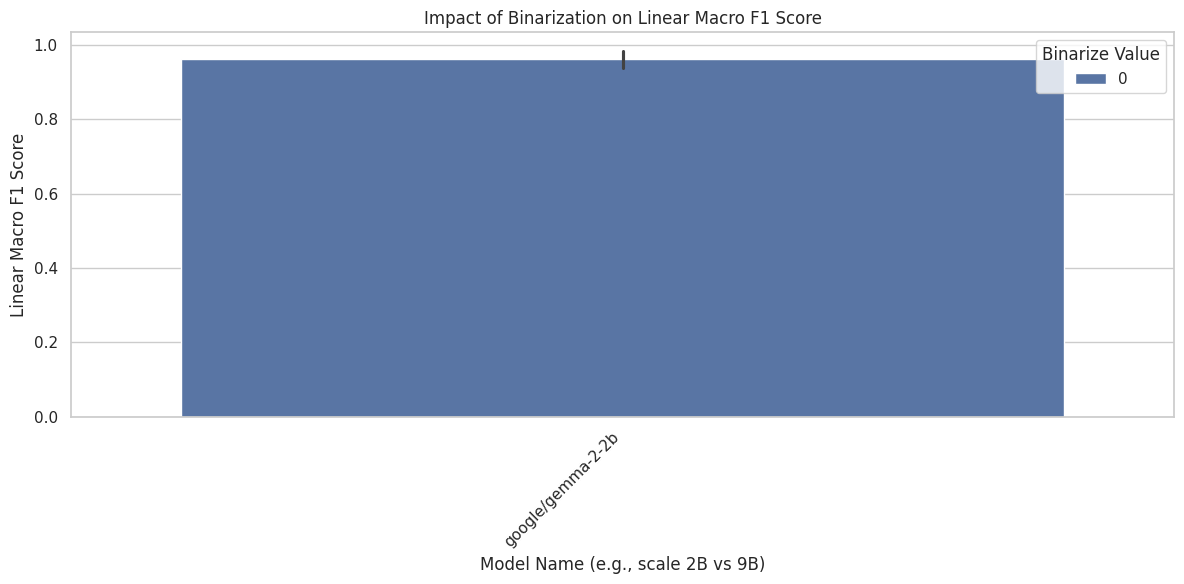

In [33]:
# --- 3. Visualization Setup ---
# Seaborn aesthetics
sns.set_theme(style="whitegrid")

# For consistent plotting, define figure size
plt.rcParams["figure.figsize"] = (12, 6)

# --- 4. Impact of Binarization on F1 Scores ---
# Compare binarize_value=0 vs binarize_value=1 for each dataset or each model_name
plt.figure()
sns.barplot(
    data=df_filtered,
    x="model_name",
    y="linear_macro_f1_score",
    hue="binarize_value",  # 0 vs. 1
    ci="sd"  # show std dev as error bars
)
plt.title("Impact of Binarization on Linear Macro F1 Score")
plt.xlabel("Model Name (e.g., scale 2B vs 9B)")
plt.ylabel("Linear Macro F1 Score")
plt.legend(title="Binarize Value", loc="best")
plt.xticks(rotation=45, ha="right")  # Rotate x labels if they overlap
plt.tight_layout()
plt.show()


<ipython-input-34-27366f21a4e0>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


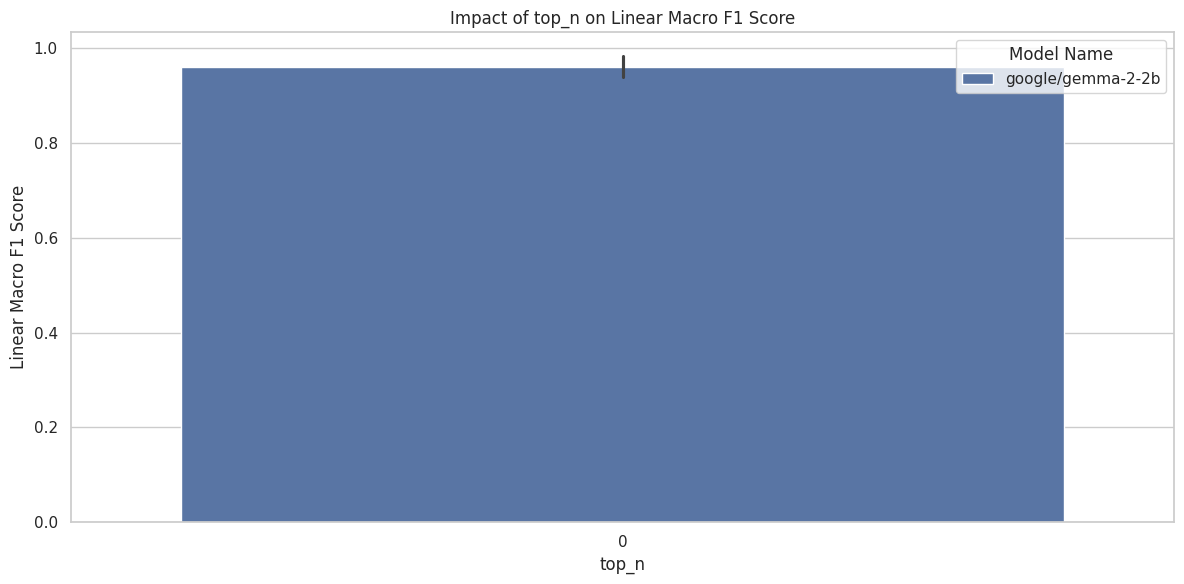

In [34]:
# --- 5. Impact of top_n on F1 Scores ---
# Compare different top_n values
plt.figure()
sns.barplot(
    data=df_filtered,
    x="top_n",
    y="linear_macro_f1_score",
    hue="model_name",  # e.g. highlight scale differences 2B vs 9B
    ci="sd"
)
plt.title("Impact of top_n on Linear Macro F1 Score")
plt.xlabel("top_n")
plt.ylabel("Linear Macro F1 Score")
plt.legend(title="Model Name", loc="best")
plt.tight_layout()
plt.show()


<ipython-input-35-5873ed9d07d3>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


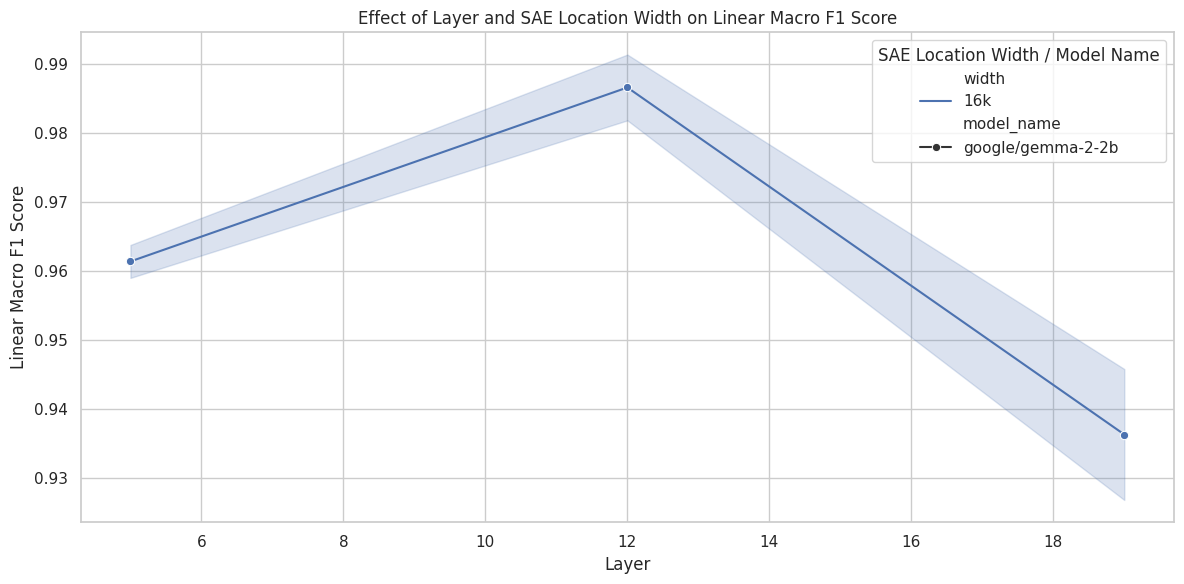

In [35]:
# --- 6. Comparing Layers and SAE Location Width ---
# Example line plot by layer
plt.figure()
sns.lineplot(
    data=df_filtered,
    x="layer",
    y="linear_macro_f1_score",
    hue="width",  # highlight different SAE location widths
    style="model_name",  # differentiates lines by model scale, e.g. 2B vs 9B
    markers=True,
    dashes=False,
    ci="sd"
)
plt.title("Effect of Layer and SAE Location Width on Linear Macro F1 Score")
plt.xlabel("Layer")
plt.ylabel("Linear Macro F1 Score")
plt.legend(title="SAE Location Width / Model Name", loc="best")
plt.tight_layout()
plt.show()


### 3.2. SAE vs. Linear Probing vs TFIDF

#### 3.2.1. Filtering for SAE and Linear Probing Data

In [37]:
sae_df = df[df["type"] == "SAE Features"]
linear_df = df[df["type"] == "Hidden States"]

#### 3.2.2. Comparison for Best SAE Hyperparameters


**Example Table Structure:**

In [38]:
# Find best SAE hyperparameters for each dataset
best_sae_params = (
    sae_df.groupby(["dataset_name"])
    .apply(lambda x: x.loc[x["linear_macro_f1_score"].idxmax()])
    .reset_index(drop=True)
)

# Merge with linear probing data for comparison
comparison_df = pd.concat([best_sae_params, linear_df])

print("Table: SAE (Best Hyperparameters) vs. Linear Probing")
display(comparison_df[["dataset_name", "type", "linear_macro_f1_score"]])

Table: SAE (Best Hyperparameters) vs. Linear Probing


<ipython-input-38-9c1f0b05b77b>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["linear_macro_f1_score"].idxmax()])


,dataset_name,type,linear_macro_f1_score
0,Anthropic/election_questions,SAE Features,0.989919
1,Anthropic/election_questions,Hidden States,0.976478
3,Anthropic/election_questions,Hidden States,0.973111
5,Anthropic/election_questions,Hidden States,0.973124
7,Anthropic/election_questions,Hidden States,0.969771
9,Anthropic/election_questions,Hidden States,0.959732
11,Anthropic/election_questions,Hidden States,0.969798


**Example Figure:**

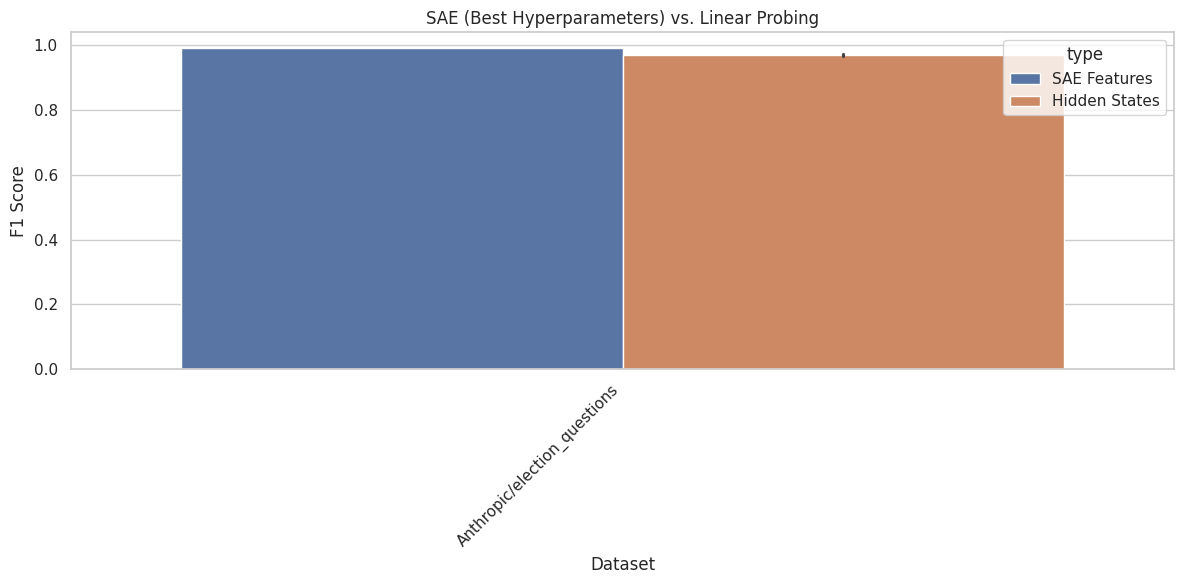

In [39]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=comparison_df,
    x="dataset_name",
    y="linear_macro_f1_score",
    hue="type",
)
plt.title("SAE (Best Hyperparameters) vs. Linear Probing")
plt.xlabel("Dataset")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
# Assuming you want to analyze a subset of layers
layers_of_interest = sorted(df["layer"].unique())
layers_df = df[df["layer"].isin(layers_of_interest)]

#### 3.3.2. Impact of Layer Choice on Performance

**\[Insert code here to generate a table and/or figure (e.g., a line plot) that shows how the F1 score changes across different layers for different datasets or tasks. You can group by other relevant parameters as well.]**

**Example Table Structure:**

In [21]:
layers_table = (
    layers_df.groupby(["dataset_name", "layer", "type"])[
        "linear_macro_f1_score"
    ]
    .agg(["mean", "std"])
    .reset_index()
)
print("Table: Impact of Layer Choice on F1 Score")
display(layers_table)

Table: Impact of Layer Choice on F1 Score


,dataset_name,layer,type,mean,std
0,Anthropic/election_questions,5,Hidden States,0.971448,0.002371
1,Anthropic/election_questions,5,SAE Features,0.961330,0.002386
2,Anthropic/election_questions,12,Hidden States,0.974794,0.002381
3,Anthropic/election_questions,12,SAE Features,0.986549,0.004766
4,Anthropic/election_questions,19,Hidden States,0.964765,0.007118
5,Anthropic/election_questions,19,SAE Features,0.936241,0.009491


**Example Figure (using a line plot):**

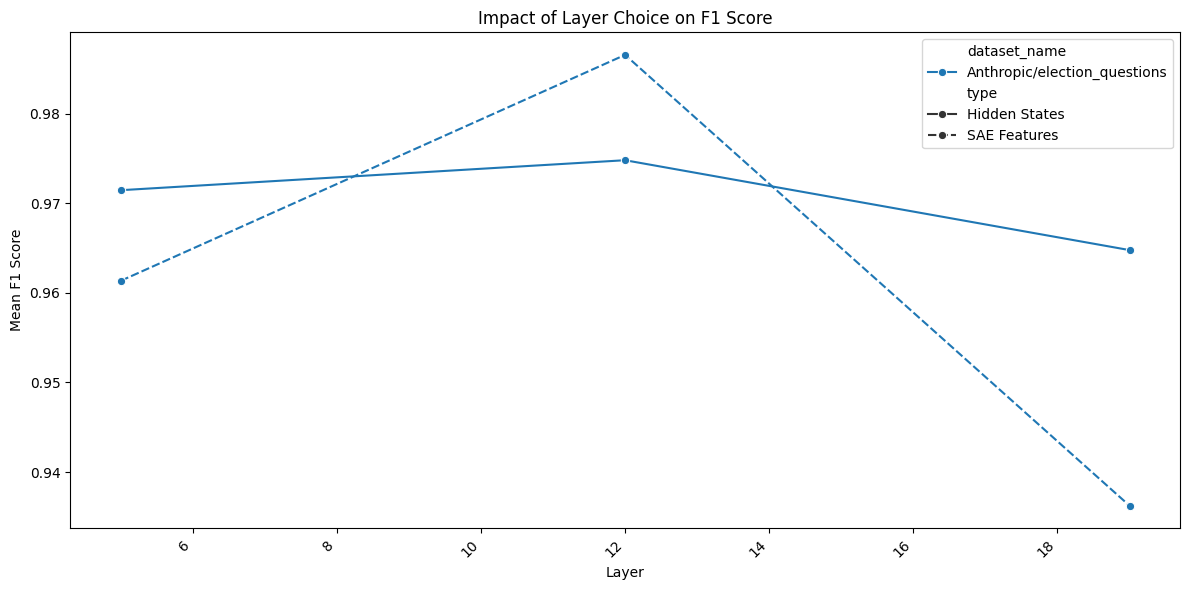

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=layers_table,
    x="layer",
    y="mean",
    hue="dataset_name",
    style="type",
    marker="o",
)
plt.title("Impact of Layer Choice on F1 Score")
plt.xlabel("Layer")
plt.ylabel("Mean F1 Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**\[Insert a description of the table/figure, explaining the trends and insights.]**

### 3.4. Generalizability Across Languages

#### 3.4.1. Filtering for Language-Specific Datasets

**\[Insert code here to filter `df` for datasets that have different language versions or splits. Create a new dataframe called `language_df`.]**

In [23]:
# Example: Assuming you have datasets with different language splits in 'dataset_split'
language_splits = ["en", "es", "de"]  # Example language codes
language_df = df[df["dataset_split"].isin(language_splits)]
language_df = language_df[language_df["type"] == "SAE Features"]

#### 3.4.2. Comparing Performance Across Languages

**\[Insert code here to generate a table and/or figure that compares the performance (e.g., F1 score) of SAEs across different languages. You can group by `dataset_name`, `dataset_split` (or a new `language` column if you create one), and other relevant parameters.]**

**Example Table Structure:**

In [24]:
language_table = (
    language_df.groupby(["dataset_name", "dataset_split", "layer"])[
        "linear_macro_f1_score"
    ]
    .agg(["mean", "std"])
    .reset_index()
)
print("Table: Performance Across Languages")
display(language_table)

Table: Performance Across Languages


,dataset_name,dataset_split,layer,mean,std


**Example Figure:**

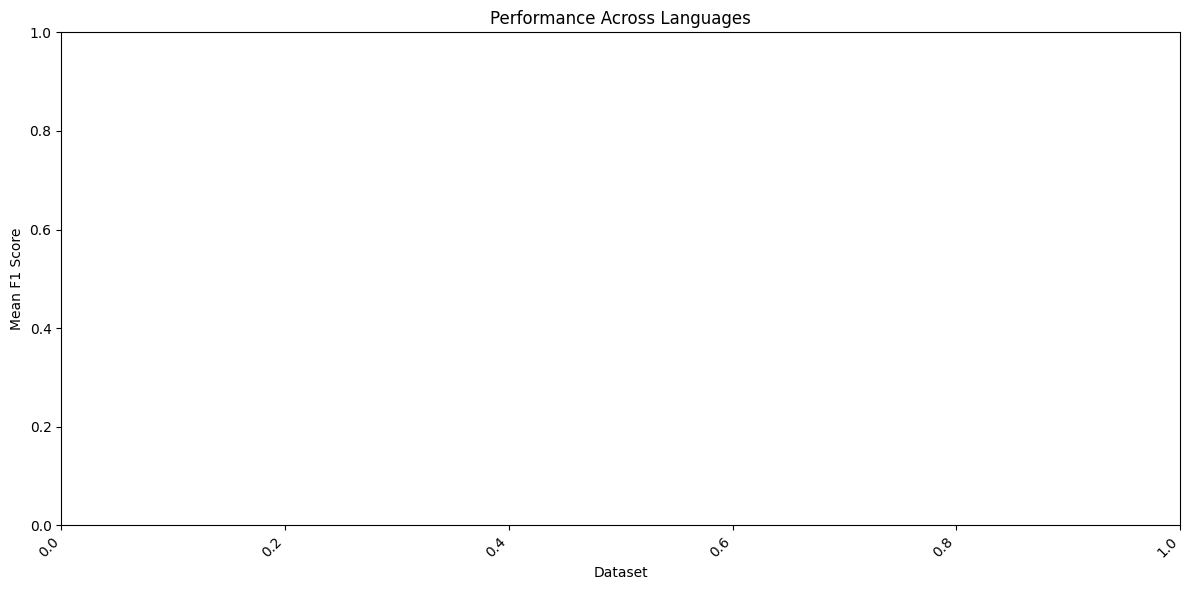

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=language_table,
    x="dataset_name",
    y="mean",
    hue="dataset_split",
    errorbar="sd",
)
plt.title("Performance Across Languages")
plt.xlabel("Dataset")
plt.ylabel("Mean F1 Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**\[Insert a description of the table/figure, explaining the trends and insights. Discuss the generalizability of SAEs across languages.]**

### 3.5. Generalizability Across Modalities

#### 3.5.1. Filtering for Image and Text Datasets

**\[Insert code here to filter `df` for datasets that represent different modalities (e.g., image datasets and text datasets). Create a new dataframe called `modality_df`.]**

In [26]:
# Example: Assuming you have a way to identify image and text datasets (e.g., in dataset_name or a separate config)
image_datasets = [
    "nelorth/oxford-flowers",
    "rajistics/indian_food_images",
    "renumics/cifar100-enriched",
]
text_datasets = [
    "AIM-Harvard/reject_prompts",
    "Anthropic/election_questions",
    "jackhhao/jailbreak-classification",
]
modality_df = df[
    df["dataset_name"].isin(image_datasets + text_datasets)
]
modality_df = modality_df[modality_df["type"] == "SAE Features"]
# Create a 'modality' column for easier grouping and plotting
modality_df["modality"] = modality_df["dataset_name"].apply(
    lambda x: "image" if x in image_datasets else "text"
)

#### 3.5.2. Comparing Performance Across Modalities

**\[Insert code here to generate a table and/or figure that compares the performance (e.g., F1 score) of SAEs across different modalities. You can group by `dataset_name`, `modality`, and other relevant parameters.]**

**Example Table Structure:**

In [27]:
modality_table = (
    modality_df.groupby(["modality", "layer", "binarize_value"])[
        "linear_macro_f1_score"
    ]
    .agg(["mean", "std"])
    .reset_index()
)
print("Table: Performance Across Modalities")
display(modality_table)

Table: Performance Across Modalities


,modality,layer,binarize_value,mean,std
0,text,5,0,0.961330,0.002386
1,text,12,0,0.986549,0.004766
2,text,19,0,0.936241,0.009491


**Example Figure:**

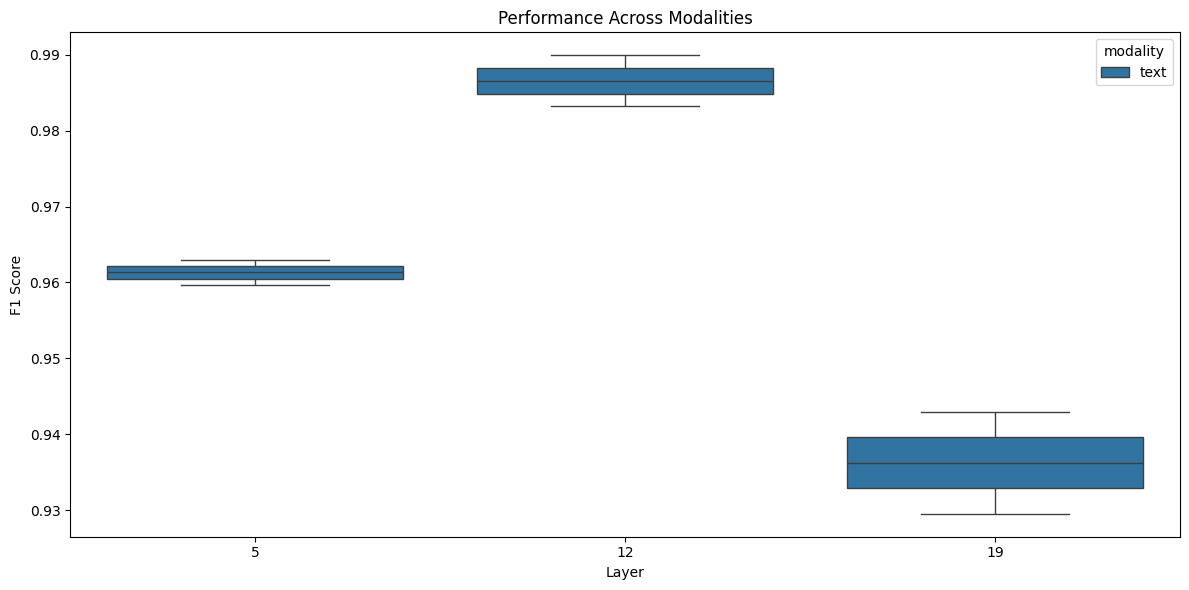

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=modality_df,
    x="layer",
    y="linear_macro_f1_score",
    hue="modality",
)
plt.title("Performance Across Modalities")
plt.xlabel("Layer")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

**\[Insert a description of the table/figure, explaining the trends and insights. Discuss the generalizability of SAEs across modalities.]**

---

## 4. Saving Results (Optional)

In [29]:
import shutil

# Define the results directory path (update with your desired path)
results_dir = "/content/drive/My Drive/sae_llava_results/results"

# Create the results directory if it doesn't exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Example: Save the output CSV to Google Drive
output_csv_path = os.path.join(results_dir, "classify_scores.csv")
shutil.copy(output_csv, output_csv_path)  # Use shutil.copy to copy within Colab

# Example: Save a figure to Google Drive
# Assuming you have a figure named 'fig' that you want to save
figure_path = os.path.join(results_dir, "figure1.png")
plt.savefig(figure_path) # Save the current figure

# Example: Save a table as a CSV to Google Drive
# Assuming you have a table named 'table_1' that you want to save
table_1_csv_path = os.path.join(results_dir, "table_1.csv")
table_1.to_csv(table_1_csv_path, index=False)

NameError: name 'table_1' is not defined

<Figure size 640x480 with 0 Axes>

---

## 5. Conclusion

**\[Write a concluding section that summarizes the key findings of your analysis. Discuss the implications of these findings for the use of SAEs in understanding and interpreting vision-language models. Highlight any limitations of your analysis and suggest directions for future work.]**

---

This completed notebook structure provides a comprehensive framework for your analysis, including placeholders for the specific explorations you wanted to perform. Remember to replace the example code and descriptions with your actual analysis and visualizations. I hope this expanded version is helpful!